# 🔬 TinyBERT Hyperparameter Optimization with PSO, SA, TS and GA

---



## Project Overview
This notebook implements and compares four metaheuristic optimization algorithms—**Particle Swarm Optimization (PSO)**, **Simulated Annealing (SA)**, **Tabu Search (TS)** and **Genetic Algorithm (GA)**—for hyperparameter tuning of a TinyBERT model on the ArXiv CS Papers multi-label classification task.

---

## About the Dataset
The project uses the [**ArXiv CS Papers Multi-Label Classification dataset**](https://www.kaggle.com/datasets/devintheai/arxiv-cs-papers-multi-label-classification-200k-v1), which contains metadata for over 200,000 computer science research papers.

- **Objective:** The goal is a multi-label classification task where each paper's abstract is used to predict its associated research categories (e.g., cs.CV, cs.AI, cs.LG).
- **Data Columns:** The key columns used are `abstract` for the model's input and `categories` for the target labels.
- **Use Case:** This dataset is ideal for developing and evaluating natural language processing (NLP) models on a large-scale, real-world text classification problem.

## Imports & Data Loading

In [ ]:
# !pip install -q kagglehub --quiet
# import kagglehub
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import random

# Download latest version of the dataset using kagglehub
# path = kagglehub.dataset_download('devintheai/arxiv-cs-papers-multi-label-classification-200k-v1')

# print(f'Dataset downloaded to: {path}')

# # List available files in the dataset
# data_files = os.listdir(path)
# print(f'Available files: {data_files}')

# Load the dataset (adjust based on actual file format)
# for file in data_files:
#     if file.endswith('.csv'):
#         df = pd.read_csv(os.path.join(path, file))
#         print(f'\nLoaded {file}')
#         print(f'Shape: {df.shape}')
#         print(f'Columns: {list(df.columns)}')
#         print(f'\nFirst few rows:')
#         print(df.head())
#         break
#     elif file.endswith('.json'):
#         df = pd.read_json(os.path.join(path, file), lines=True)
#         print(f'\nLoaded {file}')
#         print(f'Shape: {df.shape}')
#         print(f'Columns: {list(df.columns)}')
#         print(f'\nFirst few rows:')
#         print(df.head())
#         break

In [ ]:
# Check GPU
print("="*70)
print("GPU AVAILABILITY CHECK")
print("="*70)

# Check if CUDA is available
print(f"\nCUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device Count: {torch.cuda.device_count()}")
    print(f"Current GPU Device: {torch.cuda.current_device()}")
    print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Training will use CPU.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice to be used for training: {device}")
print("="*70)

GPU AVAILABILITY CHECK

CUDA Available: True
GPU Device Count: 1
Current GPU Device: 0
GPU Device Name: NVIDIA GeForce RTX 4060 Laptop GPU

Device to be used for training: cuda


In [ ]:
file_path = 'archive\cs_papers_api.csv'
df = pd.read_csv(file_path)

print(f'Loaded {file_path}')
print(f'Shape: {df.shape}')
print(f'Columns: {list(df.columns)}')
print(f'\nFirst few rows:')
print(df.head())

Loaded archive\cs_papers_api.csv
Shape: (200094, 6)
Columns: ['paper_id', 'title', 'abstract', 'year', 'primary_category', 'categories']

First few rows:
       paper_id                                              title  \
0  2301.02657v1  TarViS: A Unified Approach for Target-based Vi...   
1  2301.02642v1  Triple-stream Deep Metric Learning of Great Ap...   
2  2301.02610v1              Feedback-Gated Rectified Linear Units   
3  2301.02593v1  Multi-Agent Reinforcement Learning for Fast-Ti...   
4  2301.02561v1  Multi-Vehicle Trajectory Prediction at Interse...   

                                            abstract  \
0  The general domain of video segmentation is cu...   
1  We propose the first metric learning system fo...   
2  Feedback connections play a prominent role in ...   
3  To integrate high amounts of renewable energy ...   
4  Traditional approaches to prediction of future...   

                        year primary_category               categories  
0  2023-01-06 1

## Data Preprocessing & Splitting

In [ ]:
# Step 1: Load and prepare the Kaggle arxiv dataset
# os.makedirs('/root/.kaggle', exist_ok=True)
# import shutil
# shutil.copy('kaggle.json', '/root/.kaggle/kaggle.json')
# os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Load the dataset directly from kagglehub cache
# path = '/root/.cache/kagglehub/datasets/devintheai/arxiv-cs-papers-multi-label-classification-200k-v1/versions/1'
# df = pd.read_csv(f'{path}/cs_papers_api.csv')

# Process categories
df['categories'] = df['categories'].str.split()
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['categories'])
X = df['abstract'].fillna('').values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Dataset loaded: {len(X_train)} training samples, {len(X_val)} validation samples')
print(f'Number of labels: {y.shape[1]}')

Dataset loaded: 160075 training samples, 40019 validation samples
Number of labels: 42


## TinyBERT Model

In [ ]:
# Define TinyBERT model
class TinyBERTClassifier(nn.Module):
    def __init__(self, num_labels, dropout=0.3):
        super(TinyBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(312, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return torch.sigmoid(logits)

## Quick Subset Evaluation for Hyperparameter Tuning


In [ ]:
# Create a small subset for hyperparameter search
X_train_small = X_train[:1000]
y_train_small = y_train[:1000]
X_val_small = X_val[:200]
y_val_small = y_val[:200]

tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Quick evaluation function for hyperparameter search
def quick_evaluate(lr, dropout, batch_size):
    """Train for 4 epochs and return validation accuracy"""
    model = TinyBERTClassifier(y.shape[1], dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Prepare data
    from torch.utils.data import TensorDataset

    # Tokenize
    train_encodings = tokenizer(list(X_train_small), truncation=True, padding=True, max_length=128, return_tensors='pt')
    val_encodings = tokenizer(list(X_val_small), truncation=True, padding=True, max_length=128, return_tensors='pt')

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'],
                                  torch.tensor(y_train_small, dtype=torch.float32))
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'],
                                torch.tensor(y_val_small, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=int(batch_size))

    # Train for 4 epochs
    for epoch in range(4):
        model.train()
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.numel()

    accuracy = correct / total
    return accuracy

# Define hyperparameter bounds
# [learning_rate, dropout_rate, batch_size]
param_bounds = [(1e-5, 1e-3), (0.1, 0.6), (8, 64)]

In [ ]:
# Objective function that wraps quick_evaluate
def objective_function(params):
    lr, dropout, batch_size = params
    batch_size = int(batch_size)
    try:
        accuracy = quick_evaluate(lr, dropout, batch_size)
        return accuracy
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return 0.0

print("\n" + "="*70)
print("FINDING BEST HYPERPARAMETERS")
print("="*70)


FINDING BEST HYPERPARAMETERS


## Finding Best Hyperparameters Using Each Algorithm

### PSO

In [ ]:
# PSO optimization
class ParticleSwarmOptimization:
    def __init__(self, n_particles=10, n_iterations=15, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.convergence_history = []

    def optimize_hyperparameters(self, param_bounds, objective_function):
        n_params = len(param_bounds)
        positions = np.random.uniform(
            [b[0] for b in param_bounds],
            [b[1] for b in param_bounds],
            (self.n_particles, n_params)
        )
        velocities = np.random.uniform(-0.1, 0.1, (self.n_particles, n_params))

        personal_best_positions = positions.copy()
        personal_best_scores = np.array([objective_function(p) for p in positions])
        global_best_position = personal_best_positions[np.argmax(personal_best_scores)]
        global_best_score = np.max(personal_best_scores)

        self.convergence_history.append(global_best_score)

        for iteration in range(self.n_iterations):
            for i in range(self.n_particles):
                r1, r2 = np.random.rand(2)
                velocities[i] = (self.w * velocities[i] +
                               self.c1 * r1 * (personal_best_positions[i] - positions[i]) +
                               self.c2 * r2 * (global_best_position - positions[i]))

                positions[i] += velocities[i]
                positions[i] = np.clip(positions[i],
                                     [b[0] for b in param_bounds],
                                     [b[1] for b in param_bounds])

                score = objective_function(positions[i])

                if score > personal_best_scores[i]:
                    personal_best_scores[i] = score
                    personal_best_positions[i] = positions[i].copy()

                if score > global_best_score:
                    global_best_score = score
                    global_best_position = positions[i].copy()

            self.convergence_history.append(global_best_score)

        return global_best_position, global_best_score

In [ ]:
# Run PSO
print("Running Particle Swarm Optimization (PSO)...")
pso = ParticleSwarmOptimization(n_particles=10, n_iterations=15)
start_time = time.time()
best_params_pso, best_score_pso = pso.optimize_hyperparameters(param_bounds, objective_function)
pso_time = time.time() - start_time

print(f"\n✓ PSO BEST HYPERPARAMETERS:")
print(f"  - Learning Rate: {best_params_pso[0]:.6f}")
print(f"  - Dropout Rate: {best_params_pso[1]:.4f}")
print(f"  - Batch Size: {int(best_params_pso[2])}")
print(f"  - Validation Accuracy: {best_score_pso:.4f}")
print(f"  - Time: {pso_time:.2f}s")

Running Particle Swarm Optimization (PSO)...

✓ PSO BEST HYPERPARAMETERS:
  - Learning Rate: 0.000247
  - Dropout Rate: 0.3477
  - Batch Size: 8
  - Validation Accuracy: 0.9604
  - Time: 1483.06s


### SA

In [ ]:
# Simulated Annealing optimization
class SimulatedAnnealing:
    def __init__(self, initial_temp=100, cooling_rate=0.90, min_temp=0.01, max_iterations=50):
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.min_temp = min_temp
        self.max_iterations = max_iterations
        self.convergence_history = []

    def acceptance_probability(self, old_cost, new_cost, temperature):
        if new_cost < old_cost:
            return 1.0
        import math
        return math.exp((old_cost - new_cost) / temperature)

    def optimize_hyperparameters(self, param_bounds, objective_function):
        current_solution = np.array([np.random.uniform(b[0], b[1]) for b in param_bounds])
        current_cost = -objective_function(current_solution)

        best_solution = current_solution.copy()
        best_cost = current_cost

        self.convergence_history.append(-best_cost)

        temperature = self.initial_temp
        iteration = 0

        while temperature > self.min_temp and iteration < self.max_iterations:
            neighbor = current_solution + np.random.uniform(-0.1, 0.1, len(param_bounds))
            neighbor = np.clip(neighbor,
                             [b[0] for b in param_bounds],
                             [b[1] for b in param_bounds])

            neighbor_cost = -objective_function(neighbor)

            if self.acceptance_probability(current_cost, neighbor_cost, temperature) > np.random.random():
                current_solution = neighbor
                current_cost = neighbor_cost

                if current_cost < best_cost:
                    best_solution = current_solution.copy()
                    best_cost = current_cost

            self.convergence_history.append(-best_cost)
            temperature *= self.cooling_rate
            iteration += 1

        return best_solution, -best_cost

In [ ]:
# Run Simulated Annealing
print("Running Simulated Annealing (SA)...")
sa = SimulatedAnnealing(initial_temp=100, cooling_rate=0.90, min_temp=0.01, max_iterations=50)
start_time = time.time()
best_params_sa, best_score_sa = sa.optimize_hyperparameters(param_bounds, objective_function)
sa_time = time.time() - start_time

print(f"\n✓ SIMULATED ANNEALING BEST HYPERPARAMETERS:")
print(f"  - Learning Rate: {best_params_sa[0]:.6f}")
print(f"  - Dropout Rate: {best_params_sa[1]:.4f}")
print(f"  - Batch Size: {int(best_params_sa[2])}")
print(f"  - Validation Accuracy: {best_score_sa:.4f}")
print(f"  - Time: {sa_time:.2f}s")

Running Simulated Annealing (SA)...

✓ SIMULATED ANNEALING BEST HYPERPARAMETERS:
  - Learning Rate: 0.000956
  - Dropout Rate: 0.5983
  - Batch Size: 21
  - Validation Accuracy: 0.9592
  - Time: 325.16s


### TS

In [ ]:
# Tabu Search Optimization
class TabuSearch:
    def __init__(self, param_bounds, objective_function, tabu_tenure=2, max_iterations=50):
        self.tabu_tenure = tabu_tenure
        self.max_iterations = max_iterations
        self.param_bounds = param_bounds
        self.objective_function = objective_function
        self.tabu_list = {}
        self.history = []

    def _generate_neighbors(self, solution, step_size=0.1):
        neighbors = []
        for i in range(len(solution)):
            neighbor = solution.copy()
            neighbor[i] += step_size
            if neighbor[i] <= self.param_bounds[i][1]:
                neighbors.append(neighbor)

            neighbor = solution.copy()
            neighbor[i] -= step_size
            if neighbor[i] >= self.param_bounds[i][0]:
                neighbors.append(neighbor)
        return neighbors

    def optimize(self):
        # Initialize with a random solution
        current_solution = np.array([np.random.uniform(b[0], b[1]) for b in self.param_bounds])
        current_cost = -self.objective_function(current_solution)

        best_solution = current_solution.copy()
        best_cost = current_cost
        self.convergence_history = [-best_cost]

        for it in range(self.max_iterations):
            neighbors = self._generate_neighbors(current_solution)
            neighbor_scores = []

            # Decrement tabu tenure
            for sol in list(self.tabu_list.keys()):
                self.tabu_list[sol] -= 1
                if self.tabu_list[sol] == 0:
                    del self.tabu_list[sol]

            for neighbor in neighbors:
                neighbor_tuple = tuple(neighbor)
                if neighbor_tuple not in self.tabu_list:
                    neighbor_cost = -self.objective_function(neighbor)
                    neighbor_scores.append((neighbor, neighbor_cost))
                else:
                    # Aspiration Criterion
                    neighbor_cost = -self.objective_function(neighbor)
                    if neighbor_cost < best_cost:
                        neighbor_scores.append((neighbor, neighbor_cost))

            if not neighbor_scores:
                print("Stopping: No admissible neighbors left.")
                break

            # Choose the best neighbor
            neighbor_scores.sort(key=lambda x: x[1])
            best_neighbor, best_neighbor_cost = neighbor_scores[0]

            current_solution = best_neighbor
            current_cost = best_neighbor_cost

            # Update tabu list
            self.tabu_list[tuple(current_solution)] = self.tabu_tenure

            # Update best solution
            if current_cost < best_cost:
                best_solution = current_solution.copy()
                best_cost = current_cost

            self.convergence_history.append(-best_cost)
            self.history.append((it, current_solution, current_cost, best_solution, best_cost, self.tabu_list.copy()))

            if it % 5 == 0 or it == self.max_iterations - 1:
                print(f"Iter: {it:4d} | Current Accuracy: {-current_cost:8.4f} | Best Accuracy: {-best_cost:8.4f}")

        return best_solution, -best_cost

In [ ]:
# Run Tabu Search
print("Running Tabu Search (TS)...")
ts = TabuSearch(tabu_tenure=7, max_iterations=50, param_bounds=param_bounds, objective_function=objective_function)
start_time = time.time()
best_params_ts, best_score_ts = ts.optimize()
ts_time = time.time() - start_time

print(f"\n✓ TABU SEARCH BEST HYPERPARAMETERS:")
print(f"  - Learning Rate: {best_params_ts[0]:.6f}")
print(f"  - Dropout Rate: {best_params_ts[1]:.4f}")
print(f"  - Batch Size: {int(best_params_ts[2])}")
print(f"  - Validation Accuracy: {best_score_ts:.4f}")
print(f"  - Time: {ts_time:.2f}s")

Running Tabu Search (TS)...
Iter:    0 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:    5 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   10 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   15 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   20 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   25 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   30 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   35 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   40 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   45 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592
Iter:   49 | Current Accuracy:   0.9592 | Best Accuracy:   0.9592

✓ TABU SEARCH BEST HYPERPARAMETERS:
  - Learning Rate: 0.000436
  - Dropout Rate: 0.5330
  - Batch Size: 57
  - Validation Accuracy: 0.9592
  - Time: 1025.27s


### GA

In [ ]:
class GeneticAlgorithm:
    def __init__(self, population_size, n_generations, crossover_rate, mutation_rate, param_bounds, objective_function):
        self.population_size = population_size
        self.n_generations = n_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.param_bounds = param_bounds
        self.objective_function = objective_function
        self.n_params = len(param_bounds)

    def _initialize_population(self):
        """Creates the initial population."""
        population = []
        for _ in range(self.population_size):
            individual = np.array([np.random.uniform(b[0], b[1]) for b in self.param_bounds])
            population.append(individual)
        return population

    def _select_parents(self, population, fitness_scores):
        """Selects two parents from the population using tournament selection."""
        tournament_size = 3
        selected_parents = []
        for _ in range(2):
            tournament = random.sample(list(zip(population, fitness_scores)), tournament_size)
            tournament.sort(key=lambda x: x[1], reverse=True)
            selected_parents.append(tournament[0][0])
        return selected_parents[0], selected_parents[1]

    def _crossover(self, parent1, parent2):
        """Performs crossover between two parents to create a child."""
        if random.random() < self.crossover_rate:
            crossover_point = random.randint(1, self.n_params - 1)
            child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        else:
            child = parent1.copy()
        return child

    def _mutate(self, individual):
        """Applies mutation to an individual."""
        for i in range(self.n_params):
            if random.random() < self.mutation_rate:
                individual[i] += np.random.uniform(-0.1, 0.1)
                individual[i] = np.clip(individual[i], self.param_bounds[i][0], self.param_bounds[i][1])
        return individual

    def optimize(self):
        """Performs the Genetic Algorithm optimization."""
        population = self._initialize_population()
        best_solution = None
        best_score = -float('inf')
        self.convergence_history = []

        for gen in range(self.n_generations):
            fitness_scores = [self.objective_function(ind) for ind in population]

            for i in range(self.population_size):
                if fitness_scores[i] > best_score:
                    best_score = fitness_scores[i]
                    best_solution = population[i].copy()

            self.convergence_history.append(best_score)
            print(f"Generation: {gen:3d} | Best Score: {best_score:10.4f}")

            new_population = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = self._select_parents(population, fitness_scores)
                child1 = self._crossover(parent1, parent2)
                child2 = self._crossover(parent2, parent1)
                child1 = self._mutate(child1)
                child2 = self._mutate(child2)
                new_population.extend([child1, child2])

            population = new_population

        return best_solution, best_score

In [ ]:
# Run Genetic Algorithm
print("Running Genetic Algorithm (GA)...")
ga = GeneticAlgorithm(
    population_size=20,
    n_generations=25,
    crossover_rate=0.8,
    mutation_rate=0.2,
    param_bounds=param_bounds,
    objective_function=objective_function
)
start_time = time.time()
best_params_ga, best_score_ga = ga.optimize()
ga_time = time.time() - start_time

print(f"\n✓ GENETIC ALGORITHM BEST HYPERPARAMETERS:")
print(f"  - Learning Rate: {best_params_ga[0]:.6f}")
print(f"  - Dropout Rate: {best_params_ga[1]:.4f}")
print(f"  - Batch Size: {int(best_params_ga[2])}")
print(f"  - Validation Accuracy: {best_score_ga:.4f}")
print(f"  - Time: {ga_time:.2f}s")

Running Genetic Algorithm (GA)...
Generation:   0 | Best Score:     0.9592
Generation:   1 | Best Score:     0.9592
Generation:   2 | Best Score:     0.9592
Generation:   3 | Best Score:     0.9592
Generation:   4 | Best Score:     0.9592
Generation:   5 | Best Score:     0.9592
Generation:   6 | Best Score:     0.9592
Generation:   7 | Best Score:     0.9592
Generation:   8 | Best Score:     0.9592
Generation:   9 | Best Score:     0.9592
Generation:  10 | Best Score:     0.9592
Generation:  11 | Best Score:     0.9592
Generation:  12 | Best Score:     0.9592
Generation:  13 | Best Score:     0.9592
Generation:  14 | Best Score:     0.9592
Generation:  15 | Best Score:     0.9592
Generation:  16 | Best Score:     0.9592
Generation:  17 | Best Score:     0.9592
Generation:  18 | Best Score:     0.9592
Generation:  19 | Best Score:     0.9592
Generation:  20 | Best Score:     0.9592
Generation:  21 | Best Score:     0.9592
Generation:  22 | Best Score:     0.9592
Generation:  23 | Best 

## Best Score

In [ ]:
print("\n" + "="*70)
print("HYPERPARAMETER SEARCH COMPLETE")
print("="*70)

results = {
    "PSO": {"score": best_score_pso, "time": pso_time, "history": pso.convergence_history},
    "SA": {"score": best_score_sa, "time": sa_time, "history": sa.convergence_history},
    "Tabu Search": {"score": best_score_ts, "time": ts_time, "history": ts.convergence_history},
    "Genetic Algorithm": {"score": best_score_ga, "time": ga_time, "history": ga.convergence_history}
}

# Find the winner
winner_name = max(results, key=lambda k: results[k]["score"])

print(f"\nAlgorithm Comparison:")
print(f"  - PSO Accuracy:               {results['PSO']['score']:.4f} | Time: {results['PSO']['time']:.2f}s")
print(f"  - SA Accuracy:                {results['SA']['score']:.4f} | Time: {results['SA']['time']:.2f}s")
print(f"  - Tabu Search Accuracy:       {results['Tabu Search']['score']:.4f} | Time: {results['Tabu Search']['time']:.2f}s")
print(f"  - Genetic Algorithm Accuracy: {results['Genetic Algorithm']['score']:.4f} | Time: {results['Genetic Algorithm']['time']:.2f}s")
print("-" * 70)
print(f"  Winner: {winner_name} (Accuracy: {results[winner_name]['score']:.4f})")
print("-" * 70)

# Store these for next cells
print("\n✓ Best parameters from the winning algorithm will be used for final training.")


HYPERPARAMETER SEARCH COMPLETE

Algorithm Comparison:
  - PSO Accuracy:               0.9604 | Time: 1483.06s
  - SA Accuracy:                0.9592 | Time: 325.16s
  - Tabu Search Accuracy:       0.9592 | Time: 1025.27s
  - Genetic Algorithm Accuracy: 0.9592 | Time: 2952.48s
----------------------------------------------------------------------
  Winner: PSO (Accuracy: 0.9604)
----------------------------------------------------------------------

✓ Best parameters from the winning algorithm will be used for final training.


## Final Training and Validation

In [ ]:
def train_and_plot_model(algorithm_name, params, X_train, y_train, X_val, y_val, num_labels, n_epochs=3):
    print("\n" + "="*70)
    print(f"TRAINING TINYBERT WITH {algorithm_name.upper()} BEST HYPERPARAMETERS")
    print("="*70)

    # 1. Unpack and display hyperparameters
    lr, dropout, batch_size = params
    batch_size = int(batch_size)

    print(f"\n{algorithm_name} Hyperparameters:")
    print(f"  - Learning Rate: {lr:.6f}")
    print(f"  - Dropout: {dropout:.4f}")
    print(f"  - Batch Size: {batch_size}")

    # 2. Prepare data loaders
    tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nPreparing data on {device}...")

    # Using FULL dataset for final validation
    print(f"Training on FULL dataset: {len(X_train)} train, {len(X_val)} val samples")
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
    val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128, return_tensors='pt')

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    print(f"Data prepared: {len(train_dataset)} train, {len(val_dataset)} val samples")

    # 3. Initialize model, optimizer, and criterion
    model = TinyBERTClassifier(num_labels, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    print(f"\nTraining TinyBERT with {algorithm_name} parameters for {n_epochs} epochs...")

    # 4. Training loop
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        train_correct, train_total = 0, 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            predicted = (outputs > 0.5).float()
            train_total += labels.numel()
            train_correct += (predicted == labels).sum().item()
        train_acc = train_correct / train_total
        train_accuracies.append(train_acc)

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask)
                predicted = (outputs > 0.5).float()
                val_total += labels.numel()
                val_correct += (predicted == labels).sum().item()
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{n_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Time: {epoch_time:.2f}s")

    print(f"\n✓ {algorithm_name} Training Complete!")
    print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Final Val Accuracy: {val_accuracies[-1]:.4f}")

    # 5. Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    epochs_range = range(1, n_epochs + 1)
    ax.plot(epochs_range, train_accuracies, 'b-o', linewidth=2, markersize=8, label=f'{algorithm_name} Train Accuracy')
    ax.plot(epochs_range, val_accuracies, 'r-s', linewidth=2, markersize=8, label=f'{algorithm_name} Validation Accuracy')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'TinyBERT Training with {algorithm_name} Best Hyperparameters\nTrain vs Validation Accuracy (Full Dataset)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.01]) # Set ylim to 1.01 to ensure the top line is visible
    plt.tight_layout()
    plt.show()


TRAINING TINYBERT WITH PSO BEST HYPERPARAMETERS

PSO Hyperparameters:
  - Learning Rate: 0.000247
  - Dropout: 0.3477
  - Batch Size: 8

Preparing data on cuda...
Training on FULL dataset: 160075 train, 40019 val samples
Data prepared: 160075 train, 40019 val samples

Training TinyBERT with PSO parameters for 3 epochs...
Epoch 1/3 | Train Acc: 0.9639 | Val Acc: 0.9683 | Time: 594.44s
Epoch 2/3 | Train Acc: 0.9689 | Val Acc: 0.9697 | Time: 599.36s
Epoch 3/3 | Train Acc: 0.9709 | Val Acc: 0.9705 | Time: 600.05s

✓ PSO Training Complete!
Final Train Accuracy: 0.9709
Final Val Accuracy: 0.9705


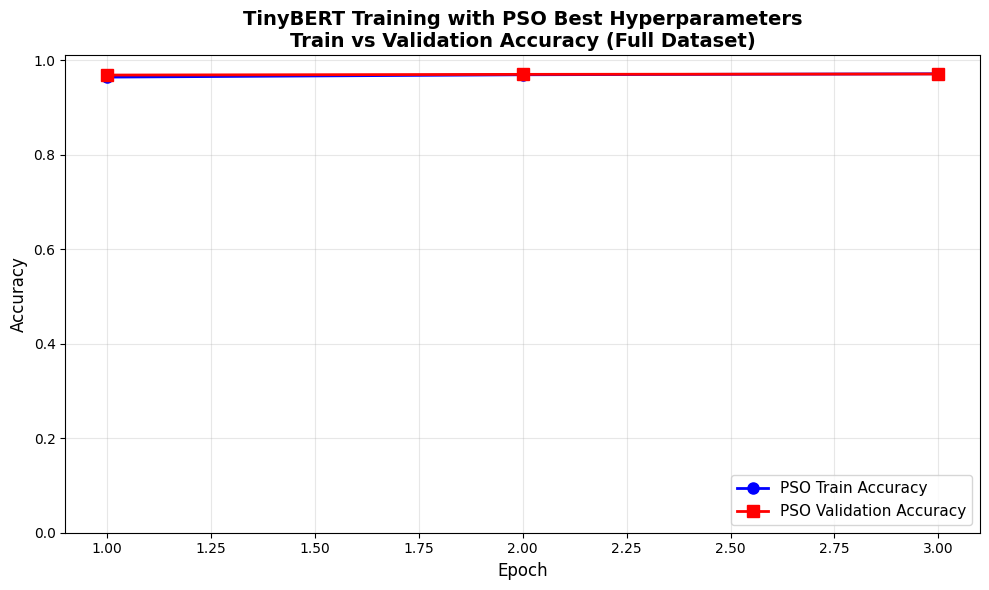


TRAINING TINYBERT WITH SA BEST HYPERPARAMETERS

SA Hyperparameters:
  - Learning Rate: 0.000956
  - Dropout: 0.5983
  - Batch Size: 21

Preparing data on cuda...
Training on FULL dataset: 160075 train, 40019 val samples
Data prepared: 160075 train, 40019 val samples

Training TinyBERT with SA parameters for 3 epochs...
Epoch 1/3 | Train Acc: 0.9595 | Val Acc: 0.9595 | Time: 269.61s
Epoch 2/3 | Train Acc: 0.9596 | Val Acc: 0.9595 | Time: 236.86s
Epoch 3/3 | Train Acc: 0.9596 | Val Acc: 0.9595 | Time: 236.04s

✓ SA Training Complete!
Final Train Accuracy: 0.9596
Final Val Accuracy: 0.9595


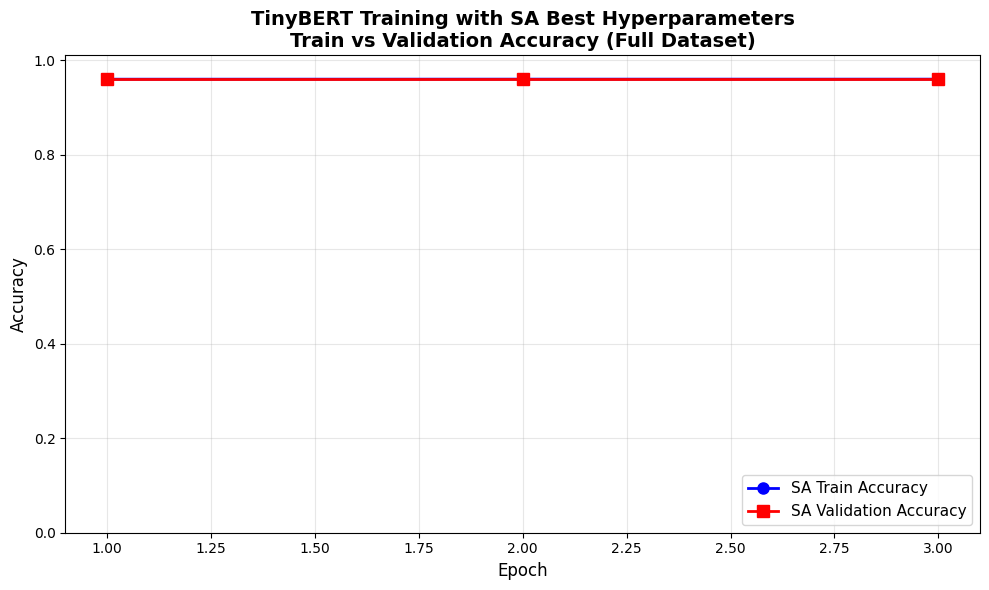


TRAINING TINYBERT WITH TABU SEARCH BEST HYPERPARAMETERS

Tabu Search Hyperparameters:
  - Learning Rate: 0.000436
  - Dropout: 0.5330
  - Batch Size: 57

Preparing data on cuda...
Training on FULL dataset: 160075 train, 40019 val samples
Data prepared: 160075 train, 40019 val samples

Training TinyBERT with Tabu Search parameters for 3 epochs...
Epoch 1/3 | Train Acc: 0.9625 | Val Acc: 0.9682 | Time: 198.37s
Epoch 2/3 | Train Acc: 0.9693 | Val Acc: 0.9700 | Time: 200.64s
Epoch 3/3 | Train Acc: 0.9716 | Val Acc: 0.9716 | Time: 198.13s

✓ Tabu Search Training Complete!
Final Train Accuracy: 0.9716
Final Val Accuracy: 0.9716


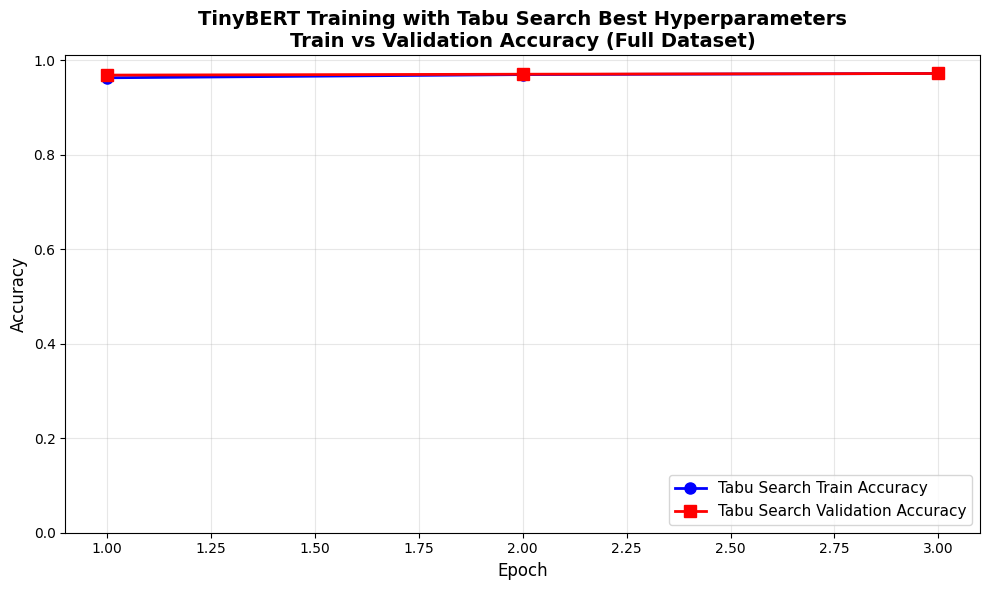


TRAINING TINYBERT WITH GENETIC ALGORITHM BEST HYPERPARAMETERS

Genetic Algorithm Hyperparameters:
  - Learning Rate: 0.000907
  - Dropout: 0.2033
  - Batch Size: 54

Preparing data on cuda...
Training on FULL dataset: 160075 train, 40019 val samples
Data prepared: 160075 train, 40019 val samples

Training TinyBERT with Genetic Algorithm parameters for 3 epochs...
Epoch 1/3 | Train Acc: 0.9594 | Val Acc: 0.9595 | Time: 199.69s
Epoch 2/3 | Train Acc: 0.9596 | Val Acc: 0.9595 | Time: 199.00s
Epoch 3/3 | Train Acc: 0.9596 | Val Acc: 0.9595 | Time: 198.99s

✓ Genetic Algorithm Training Complete!
Final Train Accuracy: 0.9596
Final Val Accuracy: 0.9595


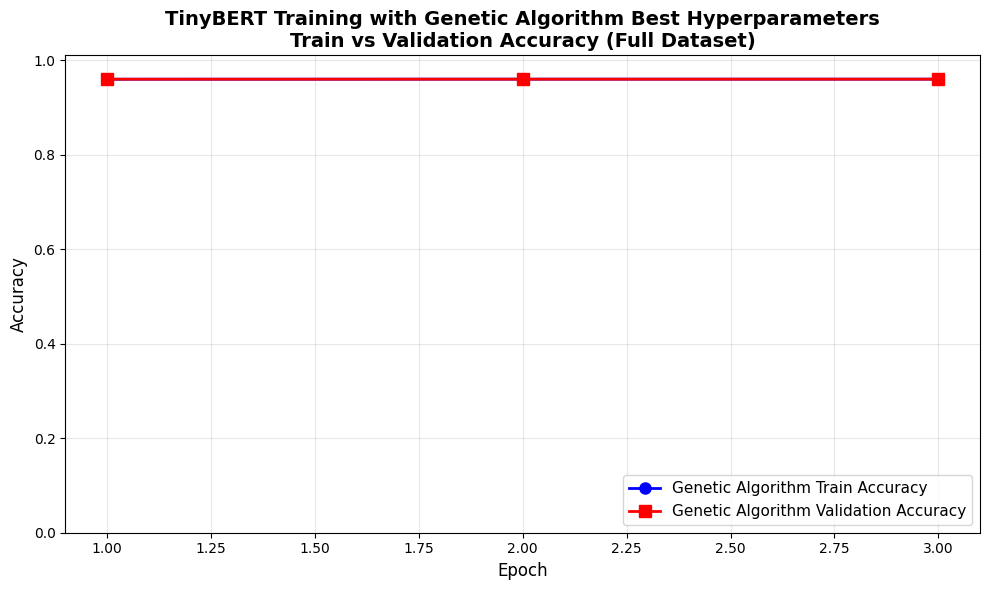


ALL FINAL VALIDATION RUNS COMPLETE


In [ ]:
# Train and plot for each algorithm
train_and_plot_model(
    algorithm_name="PSO",
    params=best_params_pso,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
    num_labels=y.shape[1]
)

train_and_plot_model(
    algorithm_name="SA",
    params=best_params_sa,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
    num_labels=y.shape[1]
)

train_and_plot_model(
    algorithm_name="Tabu Search",
    params=best_params_ts,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
    num_labels=y.shape[1]
)

train_and_plot_model(
    algorithm_name="Genetic Algorithm",
    params=best_params_ga,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
    num_labels=y.shape[1]
)

print("\n" + "="*70)
print("ALL FINAL VALIDATION RUNS COMPLETE")
print("="*70)

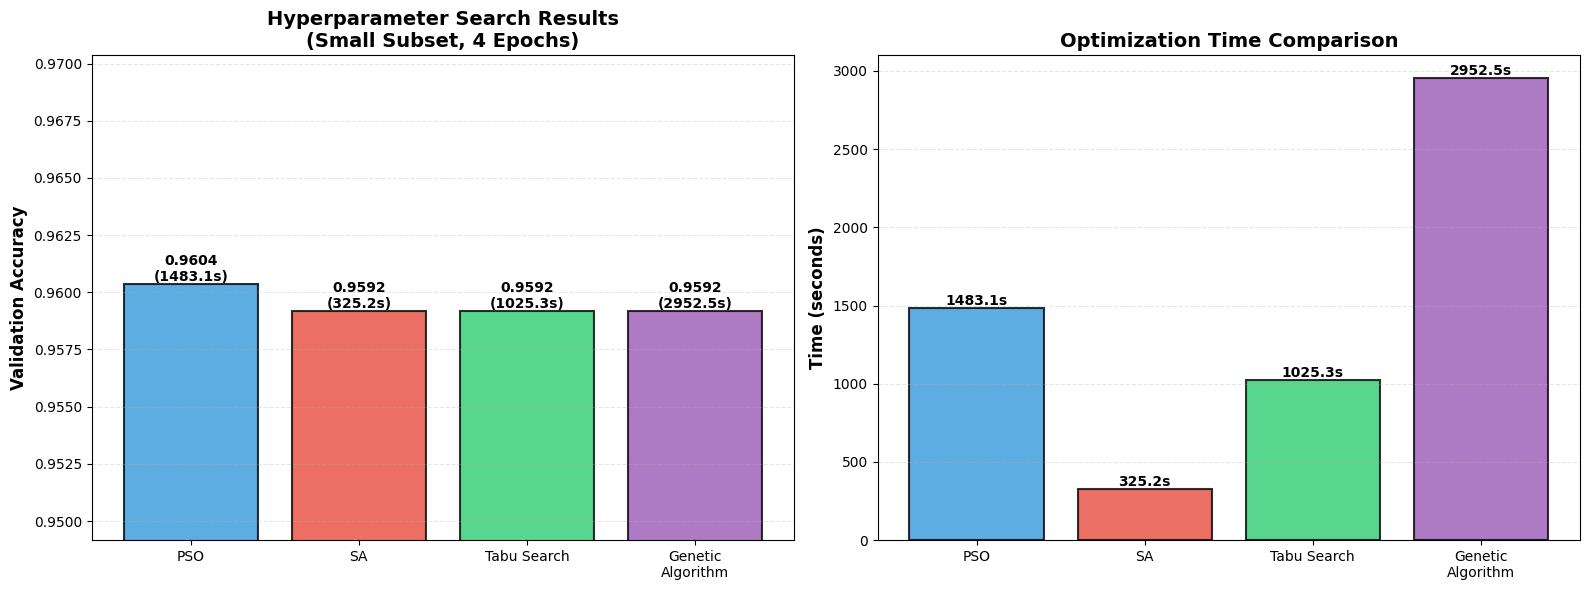


FINAL SUMMARY

Hyperparameter Search Performance (Small Subset):
  🥇 Best Algorithm: PSO
     - Accuracy: 0.9604
     - Time: 1483.06s

All Results:
  • PSO                 : 0.9604 (1483.1s)
  • SA                  : 0.9592 (325.2s)
  • Tabu Search         : 0.9592 (1025.3s)
  • Genetic Algorithm   : 0.9592 (2952.5s)


In [ ]:
# Create a comprehensive comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Hyperparameter Search Accuracy
algorithms_names = ['PSO', 'SA', 'Tabu Search', 'Genetic\nAlgorithm']
search_scores = [best_score_pso, best_score_sa, best_score_ts, best_score_ga]
search_times = [pso_time, sa_time, ts_time, ga_time]

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
bars1 = ax1.bar(algorithms_names, search_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Hyperparameter Search Results\n(Small Subset, 4 Epochs)', fontsize=14, fontweight='bold')
ax1.set_ylim([min(search_scores) - 0.01, max(search_scores) + 0.01])
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, score, time_val in zip(bars1, search_scores, search_times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}\n({time_val:.1f}s)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Optimization Time Comparison
bars2 = ax2.bar(algorithms_names, search_times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Optimization Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, time_val in zip(bars2, search_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.1f}s',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print("\nHyperparameter Search Performance (Small Subset):")
print(f"  🥇 Best Algorithm: {winner_name}")
print(f"     - Accuracy: {results[winner_name]['score']:.4f}")
print(f"     - Time: {results[winner_name]['time']:.2f}s")
print("\nAll Results:")
for name in ['PSO', 'SA', 'Tabu Search', 'Genetic Algorithm']:
    print(f"  • {name:20s}: {results[name]['score']:.4f} ({results[name]['time']:.1f}s)")
print("="*70)